In [2]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
filePath = r"D:\Here_Record\Abyss_Python\Vsc\CodeFile\caliHousing.csv"
housingDf = pd.read_csv(filePath)
housingDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<font color=#66ffcc>Found missing values in attribute 'total_bedrooms'.</font>

<font color=#66ffcc>But we'll show the data on the map before imputing.</font>

<Axes: xlabel='longitude', ylabel='latitude'>

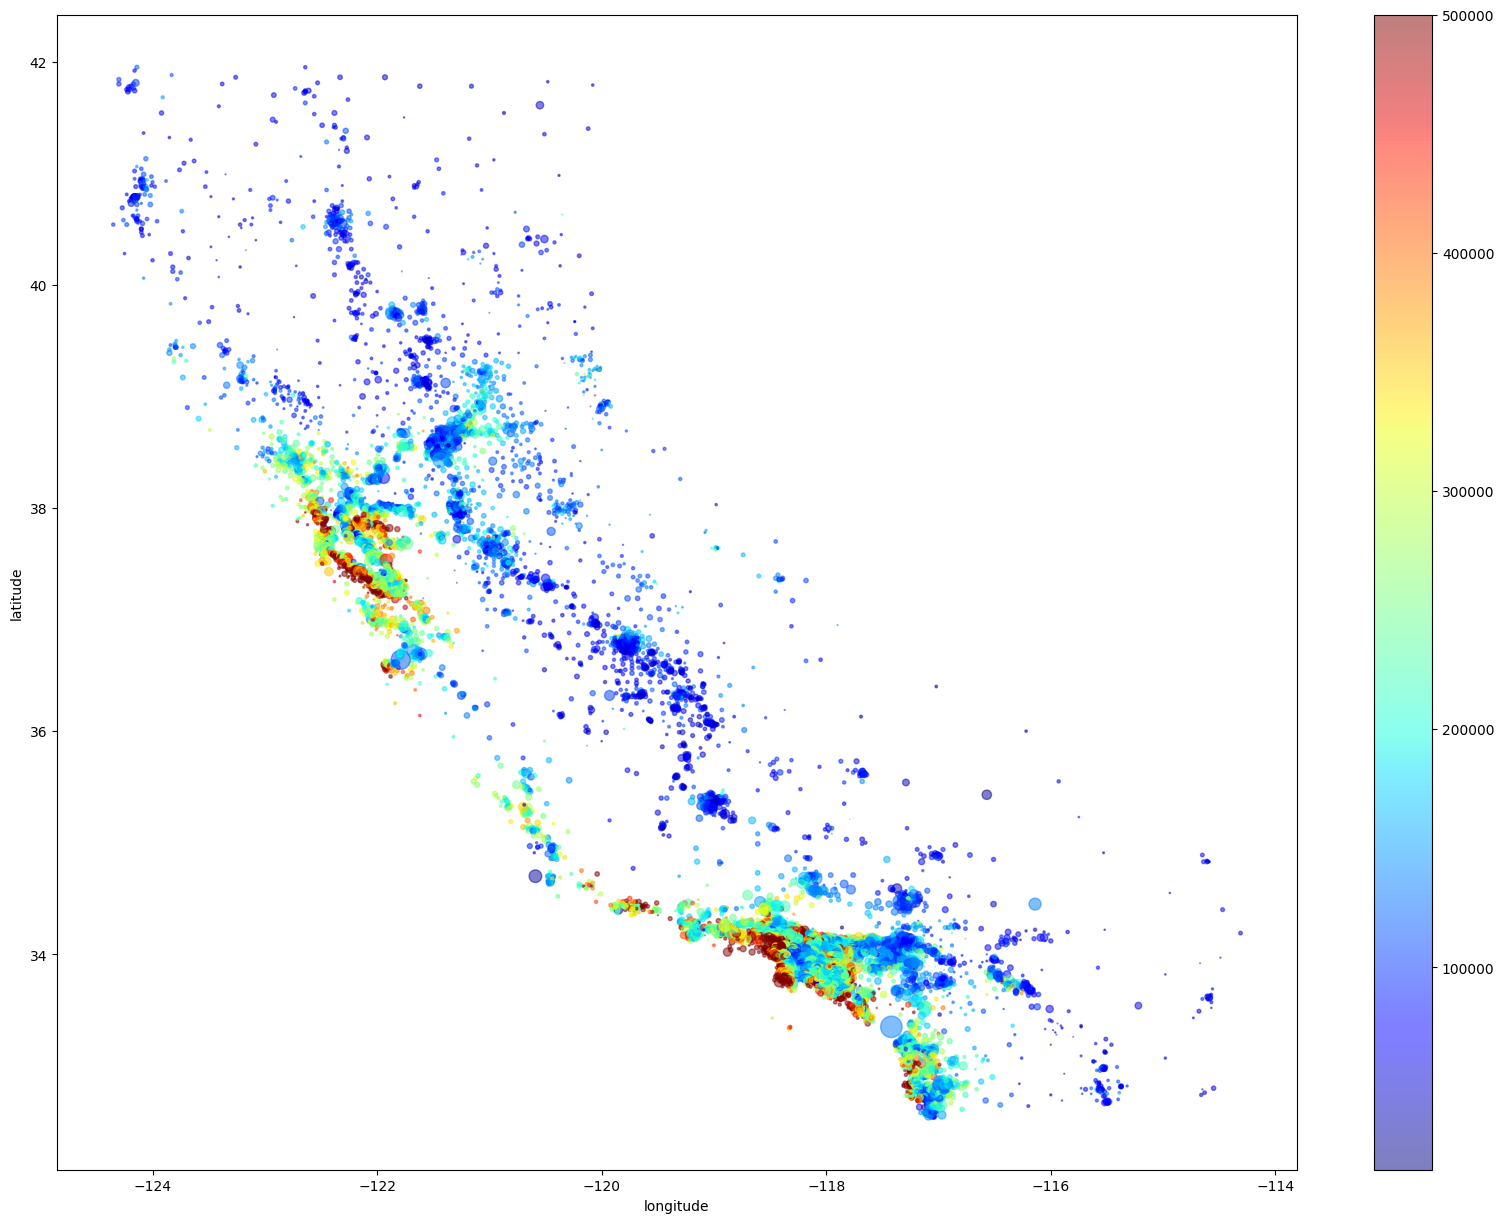

In [4]:
housingDf.plot(kind='scatter', x='longitude', y='latitude',
               alpha=0.5, s=housingDf.population/150,
               c=housingDf.median_house_value, cmap=plt.get_cmap('jet'), figsize=(20, 15))


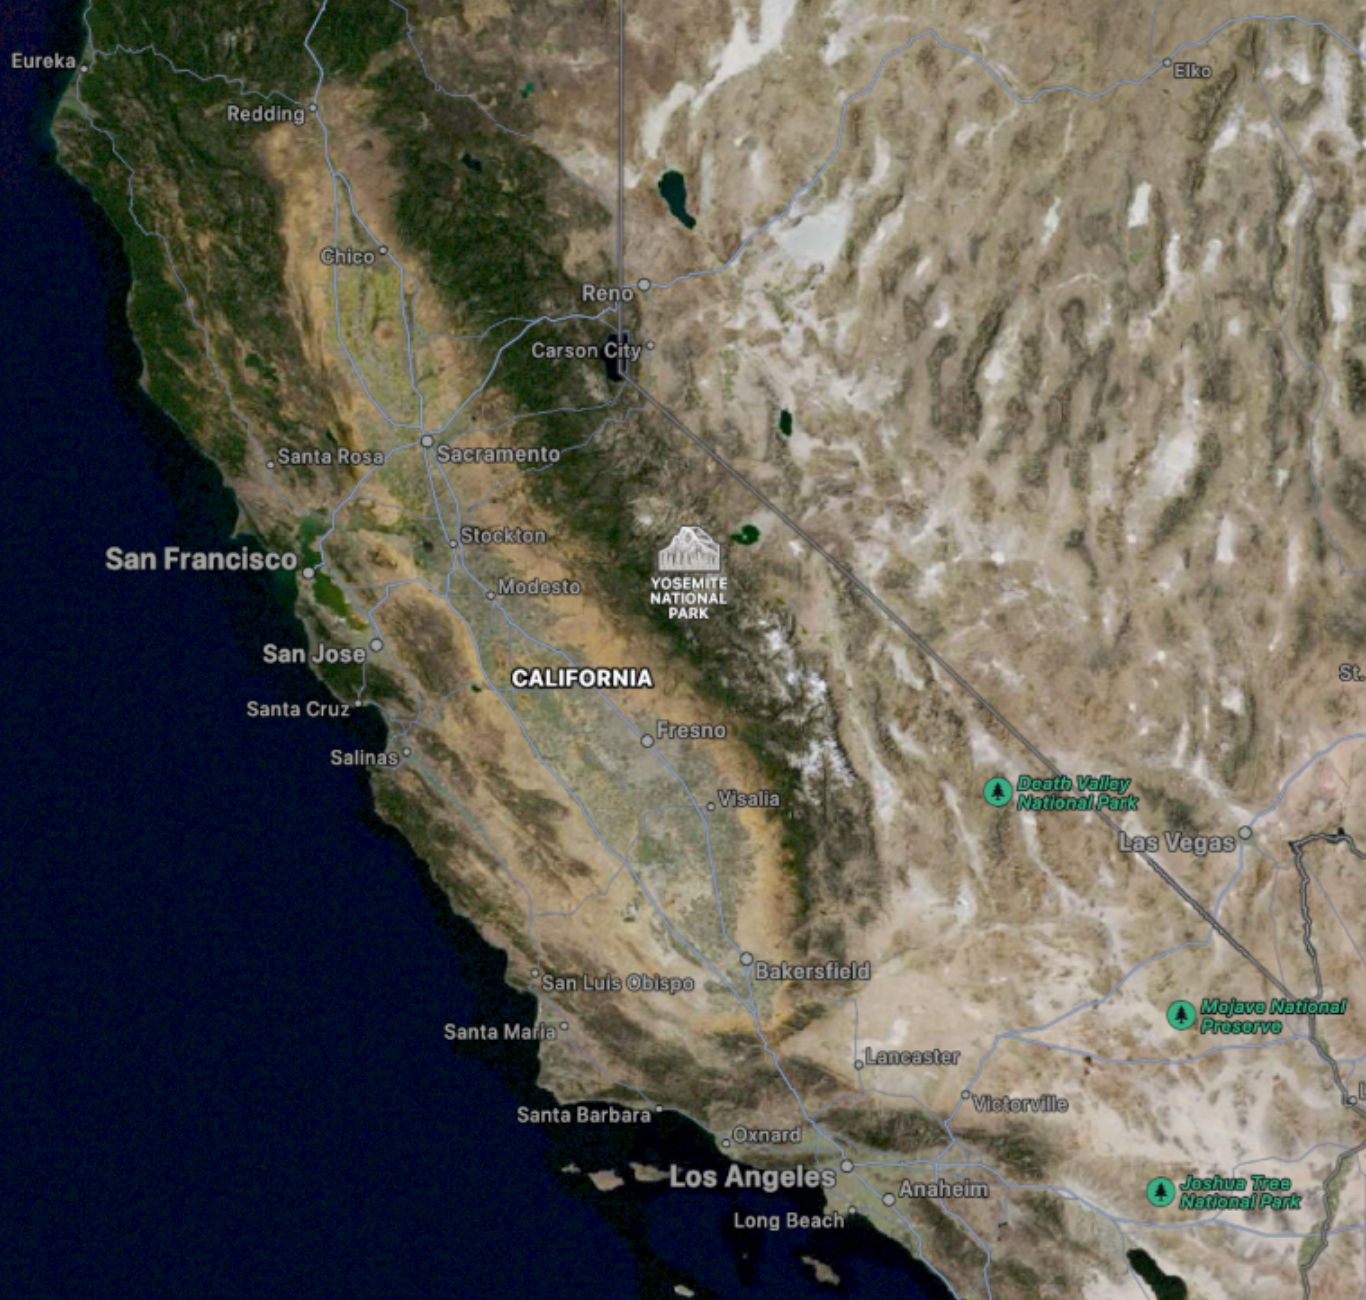

In [5]:
roomsIx, bedroomsIx, populationIx, householdsIx = 3, 4, 5, 6

class AttributesCombineAdder(BaseEstimator, TransformerMixin): # For adding new attribute
    def __init__(self, addBedroomsPerRoom=True):
        self.addBedroomsPerRoom = addBedroomsPerRoom
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        roomsPerHousehold = X[:, roomsIx] / X[:, householdsIx]
        populationPerHousehold = X[:, populationIx] / X[:, householdsIx]
        if self.addBedroomsPerRoom:
            bedroomsPerRoom = X[:, bedroomsIx] / X[:, roomsIx]
            return np.c_[X, roomsPerHousehold, populationPerHousehold,
                         bedroomsPerRoom]
        else:
            return np.c_[X, roomsPerHousehold, populationPerHousehold]


In [6]:
housingDfCp = housingDf.copy()
housingDfCp['incomeCate'] = pd.cut(housingDfCp.median_income,
                                   bins=[0, 2, 4, 6, np.inf],
                                   labels=[1, 2, 3, 4])
# Stratified sampling up to the feature 'income Categories'
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

for trainIx, testIx in sss.split(housingDfCp, housingDfCp.incomeCate):
    sssTrainSet = housingDfCp.loc[trainIx]
    sssTestSet = housingDfCp.loc[testIx]
# Remove the target/y feature
sssTrainLabels = sssTrainSet.median_house_value.copy()
sssTestLabels = sssTestSet.median_house_value.copy()

for set_ in (sssTrainSet, sssTestSet):
    set_.drop('incomeCate', axis=1, inplace=True)
    set_.drop('median_house_value', axis=1, inplace=True)
# Construct a pipline to process numerical features
numPipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('attribAdder', AttributesCombineAdder()),
                        ('stdScaler', StandardScaler())])

housingNum = sssTrainSet.drop('ocean_proximity', axis=1)
numAttribs = list(housingNum)
cateAttribs = ['ocean_proximity']
# Construct a new pipline to process both numerical and category(str) features
fullPipeline = ColumnTransformer([('num', numPipeline, numAttribs),
                                  ('cate', OneHotEncoder(), cateAttribs)])

sssTrainSet = fullPipeline.fit_transform(sssTrainSet)
sssTestSet = fullPipeline.transform(sssTestSet)


In [7]:
linReg = LinearRegression()
linReg.fit(sssTrainSet, sssTrainLabels)

scores = cross_val_score(linReg, sssTrainSet, sssTrainLabels,
                         cv=10, scoring='neg_mean_squared_error')
linRmseScore = np.sqrt(-scores).mean() # -> 68396.59.

predictions = linReg.predict(sssTestSet)
linMse = mean_squared_error(sssTestLabels, predictions)
linRmse = np.sqrt(linMse) # -> 68801.51. It's not good ... But it embodies our efforts


In [8]:
treeReg = DecisionTreeRegressor()
treeReg.fit(sssTrainSet, sssTrainLabels)

scores = cross_val_score(treeReg, sssTrainSet, sssTrainLabels,
                         cv=10, scoring='neg_mean_squared_error')
treeRmseScore = np.sqrt(-scores).mean() # -> 71598.25.

predictions = treeReg.predict(sssTestSet)
treeMse = mean_squared_error(sssTestLabels, predictions)
treeRmse = np.sqrt(treeMse) # -> 70746.25 Emm ... 


In [9]:
forestReg = RandomForestRegressor()
forestReg.fit(sssTrainSet, sssTrainLabels)

# scores = cross_val_score(forestReg, sssTrainSet, sssTrainLabels,
#                         cv=5, scoring='neg_mean_squared_error')
# forestRmseScore = np.sqrt(-scores).mean() # -> 50630.76.

predictions = forestReg.predict(sssTestSet)
forestMse = mean_squared_error(sssTestLabels, predictions)
forestRmse = np.sqrt(forestMse) # -> 49357.78


In [10]:
# Use grid searching method to tune our model (finding the best combination of n_estimators and max_features)
# And we also change the sampling method via set bootstrap to False or True(default)
paramGrid = [{'n_estimators': [3, 9, 27], 'max_features': [2, 4, 6, 8]},
             {'bootstrap': [False], 'n_estimators': [4, 10], 'max_features': [2, 3, 4]}]

gridSearch = GridSearchCV(forestReg, paramGrid, cv=3,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

gridSearch.fit(sssTrainSet, sssTrainLabels)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 9, 27]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [4, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [11]:
cvRes = gridSearch.cv_results_
for meanScore, params in zip(cvRes['mean_test_score'], cvRes['params']):
    print(np.sqrt(-meanScore), params)

65758.54444432774 {'max_features': 2, 'n_estimators': 3}
56907.18021357895 {'max_features': 2, 'n_estimators': 9}
53459.13124686175 {'max_features': 2, 'n_estimators': 27}
60930.075864276114 {'max_features': 4, 'n_estimators': 3}
53499.72411664232 {'max_features': 4, 'n_estimators': 9}
51158.095421748796 {'max_features': 4, 'n_estimators': 27}
60303.186008820216 {'max_features': 6, 'n_estimators': 3}
53547.01765983421 {'max_features': 6, 'n_estimators': 9}
50976.00509469387 {'max_features': 6, 'n_estimators': 27}
59657.53507694542 {'max_features': 8, 'n_estimators': 3}
53822.435183219524 {'max_features': 8, 'n_estimators': 9}
50927.886523098845 {'max_features': 8, 'n_estimators': 27}
60634.6564885259 {'bootstrap': False, 'max_features': 2, 'n_estimators': 4}
55521.366056166815 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
57976.529986805515 {'bootstrap': False, 'max_features': 3, 'n_estimators': 4}
52983.36498104142 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [18]:
featureImportances = gridSearch.best_estimator_.feature_importances_
extraAttribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cateEncoder = fullPipeline.named_transformers_['cate']
cate1HotAttribs = list(cateEncoder.categories_[0])
attribs = numAttribs + extraAttribs + cate1HotAttribs
sorted(zip(featureImportances, attribs), reverse=True) # The importance of the features for prediction

[(0.41740702086895864, 'median_income'),
 (0.1462677506045876, 'INLAND'),
 (0.11158883904016749, 'pop_per_hhold'),
 (0.07212590492192532, 'longitude'),
 (0.06752759689275488, 'latitude'),
 (0.04135033315989458, 'bedrooms_per_room'),
 (0.03980791406531109, 'housing_median_age'),
 (0.033057263218609516, 'rooms_per_hhold'),
 (0.015335310462530895, 'total_bedrooms'),
 (0.015191782611611318, 'total_rooms'),
 (0.01479358722791923, 'population'),
 (0.014465817397023866, 'households'),
 (0.006294966081347207, '<1H OCEAN'),
 (0.002478728052549477, 'NEAR OCEAN'),
 (0.0021732190768690126, 'NEAR BAY'),
 (0.00013396631794005548, 'ISLAND')]